In [2]:
import pandas as pd
import numpy as np

data = pd.Series(data = {
    'L':1,
    'c':1,
    'T':0.1,
    'delta': 0
})

data

L        1.0
c        1.0
T        0.1
delta    0.0
dtype: float64

In [3]:
def u0(x: float) -> float: return 1 - x
def u1(x: float) -> float: return 0
def m1(t: float) -> float: return 1
def m2(t: float) -> float: return 0
def f(t:float, x: float) -> float: return 2
def tau(h: float) -> float: return  h / data['c']

### Отображение сетки

In [4]:
import matplotlib.pyplot as plt

def print_contour(df: pd.DataFrame) -> None:
    plt.style.use('_mpl-gallery-nogrid')
    fig, ax = plt.subplots()
    X, Y = np.meshgrid(df.columns, df.index)
    Z = df.values

    contour = ax.contourf(X, Y, Z)
    cbar = fig.colorbar(contour)
    fig.set_figheight(4)
    fig.set_figwidth(6)
    ax.set_xlabel('$x_i$')
    ax.set_ylabel('$t_n$')
    fig.tight_layout()

### Метод прогонки

In [5]:
def TDMA(a, b, c, d, tn_next):
    _m1 = m1(tn_next)
    _m2 = m2(tn_next)

    n = len(d)

    alpha = np.zeros(n+1)
    beta = np.zeros(n+1)
    beta[0] = _m1
    res = np.zeros(n+1)
    res[-1] = _m2

    for i in np.arange(1, n+1):
        alpha[i] = b[i-1] / (c[i-1] - alpha[i-1] * a[i-1])

    for i in np.arange(1, n+1):
        beta[i] = (a[i-1]*beta[i-1] + d[i-1]) / (c[i-1] - alpha[i-1] * a[i-1])

    for i in np.arange(n-1, -1, -1):
        res[i] = alpha[i+1]*res[i+1] + beta[i+1]

    res = np.append(_m1, res)

    return res

In [6]:
from scipy.misc import derivative

def _implicit_scheme(y_current: list, y_prev: list, tn_current: float, h: float, tau_v: float) -> list:
    gamma = -data['c']**2 / h**2
    d = np.array([1 / tau_v ** 2 * (y_prev[i] - 2*y_current[i]) -
                  ((1 - 2 * data['delta']) * y_current[i] + data['delta'] * y_prev[i]) - 
                  f(tn_current, h * i)
                  for i in np.arange(1, len(y_current) - 1)])

    a = np.repeat(gamma, len(d))
    c = np.repeat(2 * gamma - 1 / tau_v ** 2, len(d))
    b = np.repeat(gamma, len(d))

    result = TDMA(a, b, c, d, tn_current+tau_v)

    return result


def implicit_scheme(h: float, tau_v: float) -> pd.DataFrame:
    h_values = np.linspace(0, data['L'],
                           np.int32(np.round((data['L']) / h)))

    new_h = h_values[1] - h_values[0]

    der_vals = [derivative(u0, h_val, 10e-3, 2) for h_val in h_values]
    
    l1 = [u0(i) for i in h_values[1:-1]]

    l1 = np.append(m1(0), l1)
    l1 = np.append(l1, m2(0))
    
    result = np.array(l1)

    tns = np.linspace(0, data['T'], np.int32(np.round(data['T'] / tau_v)))[2:]
    new_tau = tns[1] - tns[0]
    
    l2 = [u0(h_val) + new_tau * u1(h_val) 
          + new_tau ** 2 / 2 
          * (data['c'] ** 2 * der_vals[i] + f(0, h_val)) 
          for i, h_val in enumerate(h_values[1:-1])]

    l2 = np.append(m1(tns[0]), l2)
    l2 = np.append(l2, m2(tns[0]))

    result = np.append(result, l2)

    for tn in tns:
        l1, l2 = l2, _implicit_scheme(l2, l1, tn_current=tn, h=new_h, tau_v=new_tau)
        result = np.append(result, l2)

    result = pd.DataFrame(data=result.reshape(
        tns.shape[0]+2, -1), columns=h_values, index=np.append([0,new_tau], tns))
    result.index.name = 't_n'
    result.columns.name = 'x_i'
    return result


### Нахождение погрешностей

In [7]:
def get_innaccuracy(y_prev: float, y_curr: float) -> float:
    return np.abs((y_prev - y_curr) / y_curr)

def condition(inn: float, eps: float = 10e4) -> bool: return inn <= eps

In [8]:
def find_h(h_max: float) -> float:
    _h_min = h_max / 2
    
    first = implicit_scheme(h=h_max, tau_v=tau(h_max))
    
    y_prev = first.loc[data['T']].median()
    y_curr = implicit_scheme(h=_h_min, tau_v=tau(_h_min)).loc[data['T']].median()
    
    while (condition(get_innaccuracy(y_prev, y_curr)) == False):
        h_max /= 2
        y_prev, y_curr = implicit_scheme(h=h_max, tau_v=tau(h_max)).loc[data['T']].median()
    
    return _h_min

### Когда $\delta = 0$

In [9]:
data['delta'] = 0

In [10]:
h_min = find_h(0.025)
h_min

0.0125

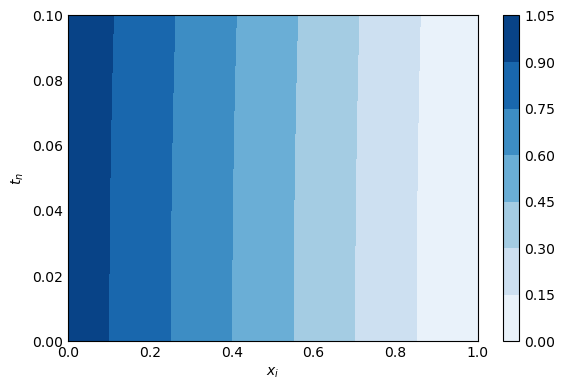

In [29]:
print_contour(implicit_scheme(h_min, tau(h_min)))

### Погрешности при изменении $\tau$

In [11]:
tau_vals = [tau(0.025 / np.power(2, i))
            for i in np.arange(4)]

tau_vals

[0.025, 0.0125, 0.00625, 0.003125]

In [12]:
values_in_midpoint = [implicit_scheme(h_min, _tau).loc[data['T']].median()
                      for _tau in tau_vals]

incrs = [get_innaccuracy(values_in_midpoint[i - 1], values_in_midpoint[i]) 
         for i in np.arange(1, len(values_in_midpoint))]

incrs

[0.0009330156242440781, 0.00037269811670624073, 0.00016821697956226957]

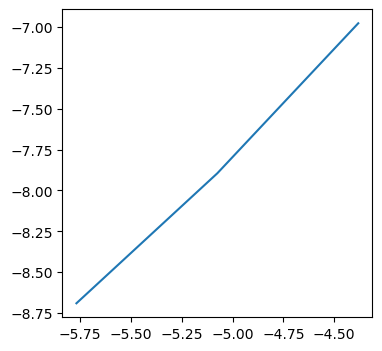

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
plt.plot(np.log(tau_vals[1:]), np.log(incrs))

In [14]:
np.polyfit(np.log(tau_vals[1:]), np.log(incrs), deg=1)

array([ 1.23578895, -1.58218503])

### Погрешности при изменении $h$

In [15]:
h_vals = [0.025 / np.power(2, i)
            for i in np.arange(4)]

h_vals

[0.025, 0.0125, 0.00625, 0.003125]

In [16]:
values_in_midpoint = [implicit_scheme(_h, tau(h_min)).loc[data['T']].median()
                      for _h in h_vals]

incrs = [get_innaccuracy(values_in_midpoint[i - 1], values_in_midpoint[i]) 
         for i in np.arange(1, len(values_in_midpoint))]

incrs

[1.4647545908410725e-11, 1.2551323192184646e-12, 2.0441965060842315e-13]

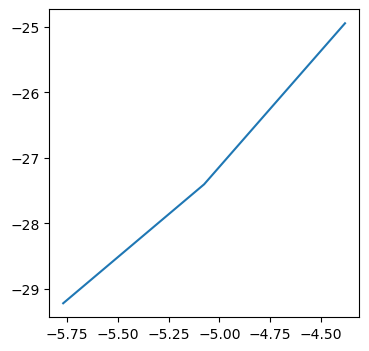

In [17]:
plt.figure(figsize=(4, 4))
plt.plot(np.log(tau_vals[1:]), np.log(incrs))

In [18]:
np.polyfit(np.log(h_vals[1:]), np.log(incrs), deg=1)

array([  3.08149064, -11.55060935])

### Когда $\delta = \frac{1}{2}$

In [31]:
data['delta'] = 0.5

In [32]:
h_min = find_h(0.025)
h_min

0.0125

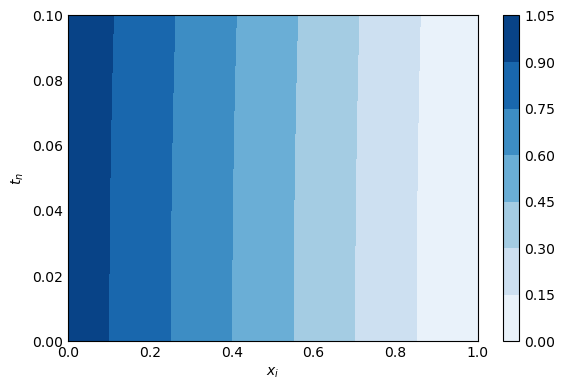

In [33]:
print_contour(implicit_scheme(h_min, tau(h_min)))

### Погрешности при изменении $\tau$

In [21]:
tau_vals = [tau(0.025 / np.power(2, i))
            for i in np.arange(4)]

tau_vals

[0.025, 0.0125, 0.00625, 0.003125]

In [22]:
values_in_midpoint = [implicit_scheme(h_min, _tau).loc[data['T']].median()
                      for _tau in tau_vals]

incrs = [get_innaccuracy(values_in_midpoint[i - 1], values_in_midpoint[i]) 
         for i in np.arange(1, len(values_in_midpoint))]

incrs

[0.00046940667459733417, 0.000188493485191339, 8.529612656518188e-05]

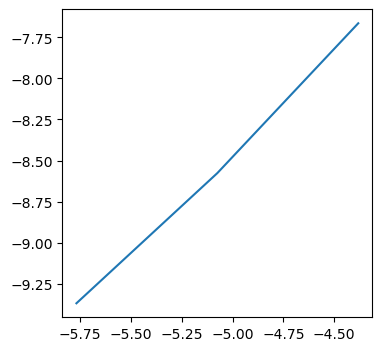

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
plt.plot(np.log(tau_vals[1:]), np.log(incrs))

In [24]:
np.polyfit(np.log(tau_vals[1:]), np.log(incrs), deg=1)

array([ 1.23014311, -2.29343312])

### Погрешности при изменении $h$

In [25]:
h_vals = [0.025 / np.power(2, i)
            for i in np.arange(4)]

h_vals

[0.025, 0.0125, 0.00625, 0.003125]

In [26]:
values_in_midpoint = [implicit_scheme(_h, tau(h_min)).loc[data['T']].median()
                      for _h in h_vals]

incrs = [get_innaccuracy(values_in_midpoint[i - 1], values_in_midpoint[i]) 
         for i in np.arange(1, len(values_in_midpoint))]

incrs

[1.3756522758126756e-11, 1.1800118690909953e-12, 1.9159986534205787e-13]

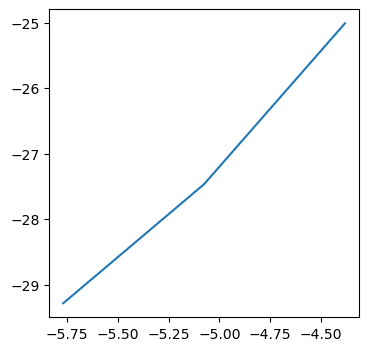

In [27]:
plt.figure(figsize=(4, 4))
plt.plot(np.log(tau_vals[1:]), np.log(incrs))

In [28]:
np.polyfit(np.log(h_vals[1:]), np.log(incrs), deg=1)

array([  3.08293774, -11.60634571])